<a href="https://colab.research.google.com/github/1000century/likelion_proj2/blob/main/code/train/v9_veter_sum_ans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install evaluate -qq
! pip install datasets -qq
! pip install bert_score -qq
! pip install rouge-score -qq
! pip install --upgrade nltk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.9 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.


In [ ]:
import gc

In [ ]:
from datasets import load_dataset, Dataset, DatasetDict
import pandas as pd
import json
import os
import zipfile
from typing import List, Dict

def flatten_json_data(data_list):
    """JSON 데이터를 평탄화하는 함수"""
    return pd.json_normalize(
        data_list,
        sep='_',
        record_path=None,
        meta=[
            'category',
            'job_field',
            'gender',
            'experience',
            ['version'],
            ['dataSet', 'answer', 'raw', 'text'],
            ['dataSet', 'answer', 'summary', 'text'],
            ['dataSet', 'question', 'raw', 'text'],
            ['dataSet', 'info', 'ageRange'],
            ['dataSet', 'info', 'channel'],
            ['dataSet', 'info', 'date'],
            ['dataSet', 'info', 'experience'],
            ['dataSet', 'info', 'gender'],
            ['dataSet', 'info', 'occupation'],
            ['dataSet', 'info', 'place'],
            ['rawDataInfo', 'answer', 'audioPath'],
            ['rawDataInfo', 'question', 'audioPath']
        ]
    )

def download_and_extract(urls: List[str], base_path: str) -> None:
    """
    URL 리스트에서 ZIP 파일을 다운로드하고 압축을 해제하는 함수
    """
    os.makedirs(base_path, exist_ok=True)

    for i, url in enumerate(urls):
        zip_file_name = url.split("/")[-1]
        zip_file_path = os.path.join("/kaggle/working", zip_file_name)
        print(f'처리중... {i+1}: {zip_file_name}')

        # wget을 사용하여 파일 다운로드
        !wget -q {url} -O {zip_file_path}

        # 압축 해제할 폴더 생성
        subfolder_name = zip_file_name.replace('.zip', '')
        subfolder_path = os.path.join(base_path, subfolder_name)
        os.makedirs(subfolder_path, exist_ok=True)

        # ZIP 파일 압축 해제
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(subfolder_path)

        # 다운로드한 ZIP 파일 삭제
        os.remove(zip_file_path)

def create_dataset_from_json_files(base_path: str) -> Dataset:
    """
    주어진 경로에서 JSON 파일들을 읽어 Dataset으로 변환하는 함수
    """
    all_data = []

    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        # 파일 경로에서 메타데이터 추출
                        folder_name = os.path.basename(os.path.dirname(file_path))
                        parts = folder_name.split('_')
                        data.update({
                            'category': parts[0],  # TL or VL
                            'job_field': '_'.join(parts[1:-2]),
                            'gender': parts[-2],
                            'experience': parts[-1]
                        })
                        all_data.append(data)
                except json.JSONDecodeError as e:
                    print(f"Error reading {file_path}: {e}")

    # JSON 데이터 평탄화
    df = flatten_json_data(all_data)

    # DataFrame을 Dataset으로 변환
    return Dataset.from_pandas(df)

def create_interview_dataset():
    """
    인터뷰 데이터셋을 생성하고 DatasetDict로 반환하는 함수
    """
    # 훈련 데이터 URL
    train_urls = [
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Male_New.zip"
    ]

    # 검증 데이터 URL
    valid_urls = [
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Male_New.zip"
    ]

    # 데이터 다운로드 및 압축 해제
    train_path = '/kaggle/working/train_unzipped'
    valid_path = '/kaggle/working/validation_unzipped'

    download_and_extract(train_urls, train_path)
    download_and_extract(valid_urls, valid_path)

    # 데이터셋 생성
    train_dataset = create_dataset_from_json_files(train_path)
    valid_dataset = create_dataset_from_json_files(valid_path)

    # DatasetDict 생성
    dataset_dict = DatasetDict({
        'train': train_dataset,
        'validation': valid_dataset
    })

    return dataset_dict

In [ ]:
# 데이터셋 생성
dataset = create_interview_dataset()

# 데이터셋 정보 출력
print("\nDataset Info:")
print(dataset)

# 훈련 데이터 샘플 확인
print("\nTraining Data Sample:")
print(dataset['train'][0])

# 검증 데이터 샘플 확인
print("\nValidation Data Sample:")
print(dataset['validation'][0])

# 데이터셋을 로컬이나 HuggingFace Hub에 저장하기
# dataset.save_to_disk("path/to/local/directory")  # 로컬에 저장
# dataset.push_to_hub("username/dataset-name")     # HuggingFace Hub에 업로드

처리중... 1: TL_01.Management_Female_Experienced.zip
처리중... 2: TL_01.Management_Female_New.zip
처리중... 3: TL_01.Management_Male_Experienced.zip
처리중... 4: TL_01.Management_Male_New.zip
처리중... 5: TL_02.SalesMarketing_Female_Experienced.zip
처리중... 6: TL_02.SalesMarketing_Female_New.zip
처리중... 7: TL_02.SalesMarketing_Male_Experienced.zip
처리중... 8: TL_02.SalesMarketing_Male_New.zip
처리중... 9: TL_03.PublicService_Female_Experienced.zip
처리중... 10: TL_03.PublicService_Female_New.zip
처리중... 11: TL_03.PublicService_Male_Experienced.zip
처리중... 12: TL_03.PublicService_Male_New.zip
처리중... 13: TL_04.RND_Female_Experienced.zip
처리중... 14: TL_04.RND_Female_New.zip
처리중... 15: TL_04.RND_Male_Experienced.zip
처리중... 16: TL_04.RND_Male_New.zip
처리중... 17: TL_05.ICT_Female_Experienced.zip
처리중... 18: TL_05.ICT_Female_New.zip
처리중... 19: TL_05.ICT_Male_Experienced.zip
처리중... 20: TL_05.ICT_Male_New.zip
처리중... 21: TL_06.Design_Female_Experienced.zip
처리중... 22: TL_06.Design_Female_New.zip
처리중... 23: TL_06.Design_Male_Ex

In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import load_dataset
import numpy as np

In [ ]:
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained(
    "skt/kogpt2-base-v2",
    bos_token='</s>',
    eos_token='</s>',
    unk_token='<unk>',
    pad_token='<pad>',
    mask_token='<mask>'
)

tokenizer.json:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
dataset['train'][0]

{'version': '1.0',
 'category': 'TL',
 'job_field': '06.Design',
 'gender': 'Male',
 'experience': 'Experienced',
 'dataSet_info_date': '20230116',
 'dataSet_info_occupation': 'ARD',
 'dataSet_info_channel': 'MOCK',
 'dataSet_info_place': 'ONLINE',
 'dataSet_info_gender': 'MALE',
 'dataSet_info_ageRange': '35-44',
 'dataSet_info_experience': 'EXPERIENCED',
 'dataSet_question_raw_text': '이 직무에 지원한 이유가 무엇인지 말씀해 주시기 바랍니다 본인이 왜 적합한 인재인지도 설명해 주시기 바랍니다',
 'dataSet_question_raw_wordCount': 15,
 'dataSet_question_emotion': [],
 'dataSet_question_intent': [],
 'dataSet_answer_raw_text': '이유는 저는 여전히 기자이고 그리고 취재를 하고 싶고 그리고 제가 취재한 기사를 네 내보내 줄 회사가 필요하고 언론사가 필요하고 그래서 지원을 하게 되었고요. 이제 뭐 워낙에 음 그러니까 플랫폼은 많잖아요. 어떠한 정보를 알릴 수 있는 플랫폼 그 플랫폼 자체는 많지만 그래도 공신력 있는 플랫폼이 사람들에게 가장 빠르고 쉽게 다가갈 수 있으니까 무시 못하죠. 저부터도 그러는데요. 뭐 그래서 그거를 토대로 봤을 때 이 회사가 저에게 지금 가장 적합한 회사라고 생각을 해서 지원을 하게 되었고요. 저는 뭐 길다고 하기도 애매하고 짧다고 하기도 애매한 그냥 그냥 그런 그저 그런 정도의 경력을 지금 가지고 있는데 그럼에도 불구하고 어떤 신입 때의 그런 패기는 여전한 편이라고 자부해서요. 그래서 저는 이 정도 규모의 회사에서 적합한 인재라고 생

In [ ]:
def preprocess_training_examples(examples):
    max_length=256
    formatted_inputs = [
        f"</s> 경력상태: {'신입' if v == 'NEW' else '경력직'} 질문: {q} 답변: {a} </s>"
        for v,q,a in zip(examples["dataSet_info_experience"],examples["dataSet_answer_summary_text"],examples["dataSet_answer_raw_text"])
    ]
    inputs = tokenizer(
        formatted_inputs,
        max_length=max_length,
        truncation= True,
        padding="max_length",
        return_tensors="pt"
    )

    labels = inputs['input_ids'].clone()
    labels[labels==tokenizer.pad_token_id] = -100
    inputs['labels'] = labels
    return inputs


train_dataset = dataset['train'].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=dataset['train'].column_names,
    load_from_cache_file=False  # 이 옵션 추가
)

val_dataset = dataset['validation'].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=dataset['validation'].column_names,
    load_from_cache_file=False  # 이 옵션 추가
)

Map:   0%|          | 0/68074 [00:00<?, ? examples/s]

Map:   0%|          | 0/8026 [00:00<?, ? examples/s]

In [ ]:
print(len(train_dataset))
# # 코드 잘 돌아가는지 확인 위해 train_dataset 임의로 매우 적은 개수로 샘플링
# from torch.utils.data import Subset
# train_dataset = Subset(train_dataset, indices=range(40))
# val_dataset = Subset(val_dataset, indices=range(80))
print(len(train_dataset))
print(len(val_dataset))

68074
68074
8026


# Model

In [ ]:
import torch
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast

model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51200, bias=False)
)

In [ ]:
import psutil
import os

def log_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Current memory usage: {process.memory_info().rss / 1e6} MB")


In [ ]:
from transformers import Trainer
import evaluate

In [ ]:
import evaluate
import numpy as np
import torch
from rouge_score import rouge_scorer
meteor = evaluate.load('meteor')
bertscore = evaluate.load('bertscore')
bleu = evaluate.load('bleu')

def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        logits = logits[0]
    pred_ids = torch.argmax(logits, dim=-1)
    return pred_ids, labels

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Predictions 튜플 처리
    print("\n", '='*50,"\nPredictions type:", type(predictions))
    if isinstance(predictions, tuple):
        predictions = predictions[0]
    # Predictions와 Labels를 numpy 배열로 변환
    if isinstance(predictions, torch.Tensor):
        print("Converting Predictions to numpy...")
        predictions = predictions.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        print("Converting Labels to numpy...")
        labels = labels.cpu().numpy()

    # Decode predictions and labels
    print("Decoding predictions and labels...")
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0)
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=False)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=False)

    # Post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]
    print("Decoded Predictions Sample:\n", decoded_preds[:3])
    print("Decoded Labels Sample:\n", decoded_labels[:3])

    # Calculate ROUGE metrics using rouge-score
    print("Calculating ROUGE...")
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {
        'rouge1': [],
        'rouge2': [],
        'rougeL': []
    }

    for pred, label in zip(decoded_preds, decoded_labels):
        if pred and label:  # 둘 다 비어있지 않은 경우만 계산
            scores = scorer.score(label, pred)
            rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
            rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
            rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

    print("\nROUGE scores details:")
    print(f"Number of valid pairs: {len(rouge_scores['rouge1'])}")
    if rouge_scores['rouge1']:
        print(f"Sample ROUGE-1 scores: {rouge_scores['rouge1'][:5]}")

    rouge_result = {
        'rouge1': np.mean(rouge_scores['rouge1']) * 100 if rouge_scores['rouge1'] else 0,
        'rouge2': np.mean(rouge_scores['rouge2']) * 100 if rouge_scores['rouge2'] else 0,
        'rougeL': np.mean(rouge_scores['rougeL']) * 100 if rouge_scores['rougeL'] else 0
    }

    # Calculate other metrics
    print("Calculating METEOR...")
    meteor_result = meteor.compute(predictions=decoded_preds, references=decoded_labels)
    print("METEOR result:", meteor_result)

    print("Calculating BERTScore...")
    bertscore_result = bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang="ko", device='cuda' if torch.cuda.is_available() else 'cpu')
    print("BERTScore finished")

    print("Calculating BLEU...")
    bleu_result = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    print("BLEU result:", bleu_result)

    # Combine results
    result = {
        **rouge_result,
        "meteor": round(meteor_result["meteor"] * 100, 4),
        "bertscore_f1": round(np.mean(bertscore_result["f1"]) * 100, 4),
        "bleu": round(bleu_result["bleu"] * 100, 4)
    }

    print("Calculating generated length...")
    result['gen_len'] = np.mean([len(pred.split()) for pred in decoded_preds])
    print("Final Metrics:", result)

    return result

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [ ]:
from transformers import Trainer, TrainingArguments

# Training arguments 설정
training_args = TrainingArguments(
    output_dir='./results',          # 모델이 저장될 경로
    evaluation_strategy="epoch",    # 매 에포크마다 평가
    save_strategy="epoch",          # 매 에포크마다 저장
    learning_rate=5e-5,             # 기본 학습률
    per_device_train_batch_size=16,  # 각 디바이스에서의 배치 사이즈
    per_device_eval_batch_size=32,   # 평가 시의 배치 사이즈
    eval_accumulation_steps=8,      # 평가 시 gradient accumulation steps
    num_train_epochs=6,             # 에포크 수
    weight_decay=0.01,              # 가중치 감쇠
    save_total_limit=2,             # 저장할 체크포인트 개수 제한
    logging_dir='./logs',           # 로깅 파일 저장 위치
    logging_steps=500,              # 로깅 빈도
    load_best_model_at_end=True,    # 가장 좋은 모델을 끝에서 로드
    eval_steps=1000,                # 평가 빈도
    fp16=True,                      # Mixed Precision (FP16) 사용
    dataloader_num_workers=4,       # DataLoader에서 사용할 워커 수
    deepspeed=None,                 # DeepSpeed는 사용하지 않음
    report_to="none",               # 로깅 서비스 (TensorBoard 등 사용하지 않음)
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer
import numpy as np

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    compute_metrics=compute_metrics,
)

# DataLoader 확인 및 메모리 상태 출력
print(f"Total train batches: {len(trainer.get_train_dataloader())}")
print(f"Total eval batches: {len(trainer.get_eval_dataloader())}")
print(f"Batch size train: {training_args.per_device_train_batch_size}")
print(f"Batch size eval: {training_args.per_device_eval_batch_size}")
print(f"Eval accumulation steps: {training_args.eval_accumulation_steps}")

Total train batches: 2128
Total eval batches: 126
Batch size train: 16
Batch size eval: 32
Eval accumulation steps: 8


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [ ]:
import warnings
import os

# fork 관련 경고 제거
warnings.filterwarnings('ignore', message="os.fork()")

# tokenizer 경고 제거
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# autocast 경고 제거
warnings.filterwarnings('ignore', message="`torch.cuda.amp.autocast")

# gather 경고 제거
warnings.filterwarnings('ignore', message="Was asked to gather along dimension 0")

In [ ]:
# 학습 시작
trainer.train()


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Meteor,Bertscore F1,Bleu,Gen Len
1,2.909400,2.855737,5.687770,0.169908,5.681541,22.648700,72.556800,8.825100,183.492524
2,2.759400,2.806437,5.631308,0.116708,5.625078,22.749200,72.563100,8.539800,174.239721
3,2.651600,2.784111,5.619340,0.128453,5.619340,22.991300,72.665100,8.399000,167.573636
4,2.572300,2.767072,5.641684,0.155251,5.635454,23.170300,72.987300,7.948200,155.448542
5,2.506200,2.762287,5.657997,0.136632,5.651768,23.248000,73.018500,8.204700,158.646275
6,2.455000,2.761382,5.656450,0.141448,5.650220,23.267600,72.949900,8.197500,159.788188



Predictions type: <class 'tuple'>
Decoding predictions and labels...
Decoded Predictions Sample:
 ['경력상태: 신입직 질문: 저는 이박한 상황이에서는 항상 필요한 하는 일들을 먼저 그순위를 정하는둡니다. 우선음에는 시간을디션을 중요장히 중요하기 때문에 우선 더 세를 해서 뒤에 우선 가지하게 분류 분류 것들을를 해서 해 시간을을 짜고 편입니다. 답변: 네 저는 촉 촉 촉박한 상황 속에서도 꼭박한 상황 속에서도 것 어면서도 꼭 꼭 해야 되는 것들을 분류 단위로 하고를 합니다. 우선 그다음 제 이제순위를 둡니다. 어 그 제가박한하게 어 해야 일을 해야 해야 되는 일 있을 있을 거 때문에 그 것들을를 좀 그줄 짜서 미루<unk> 밀 그다 그 당장 때 없는 때문에 그 거 어 어음에 제 제 내해야 나가 게 중요 그 이제 이제 세단은위를  세 순위는 뭐 이 우선도가든지 아니면면은 뭐 이런 순 뭐 뭐 해야부터 해야 되는 그런부터 시간에에는 되는 것 이런 뭐 이 가지 뭐 있을잖. 그래서 이런 그든은걸 그 따라서 분류 그라든가 이런 것들을 해서리를 해서를 하고 편입이고요. 그다 세장은도 뭐 이제 컨디션도부도 굉장히 중요하기요. 그다 조금 크게 분류를 한 한 다음에 세세하게 하나하나 세부테일하게 분류를 순서대로 하면서 플랜을 짜는 편입니다. </s>', '경력상태: 신입직 질문: 저 프로세 회사의 정해져 전부터 진행왔 일 직무일과 아니기있는기 때문에 그지 하지만 다니라면 스타 스타일을 잘 싶습니다. 않습니다. 답는 이 업무일을 고집하고 수 답 견디 주셔 바랍니다. 답변: 네요. 저는 채용간 해왔던 제의 스타일이 배어 배어있기 때문에 어렵습니다. 회사를은 이미 저 이미 이미 일이 아니고 저들도니까 제는 그 위해서 일을 제가 그이 하고 어 그 하고 어 하는 것도 때문에 어 입장에서 해서 저적으로 맞는게 업무리를만만서 라고을라야 라고 하는 것은는 아닙하다고 생각합니다. 그래서 저 사람을 있고 거이기 그 보

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BERTScore finished
Calculating BLEU...
BLEU result: {'bleu': 0.088250559101374, 'precisions': [0.38145506206629104, 0.2003610108303249, 0.1281655005480109, 0.08755097766068058], 'brevity_penalty': 0.515697803723519, 'length_ratio': 0.6015998935198928, 'translation_length': 1609086, 'reference_length': 2674678}
Calculating generated length...
Final Metrics: {'rouge1': 5.6877703694781, 'rouge2': 0.1699078202167788, 'rougeL': 5.681540616176331, 'meteor': 22.6487, 'bertscore_f1': 72.5568, 'bleu': 8.8251, 'gen_len': 183.49252429603789}

Predictions type: <class 'tuple'>
Decoding predictions and labels...
Decoded Predictions Sample:
 ['경력상태: 신입직 질문: 저는 이박한 상황이에서는 침착 해야 하는 일을 먼저 그순위를 정둡니다. 우선음에는 시간디션을 체크장히 중요하기 때문에 우선 더 세를 해서 뒤에 그 번째하게 분류 체크 것들을를 해 해 시간을을 짜 편입니다. 답변: 어 저는 촉 촉 촉박한 상황 속에서도 꼭박한 상황 속에서도 것 알면서도 꼭 꼭 해야 되는 것들을 분류류를 합니다.를 합니다.요. 그다음에 어 우선순위를 둡니다. 어 그 그박한하다 어 해야 촉 해야 해야 되는 일 있을 있을 텐 때문에 그 것들을를 조금 그줄 짜 미루둡 밀 그래서 그 당장 때는 없는 때문에 그 거 조금 어음에 제 제 해야해야 나가 게 아니라 그 이제 처리를 플랜 처리를위로 이제 일 순위 뭐 이 

There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=12768, training_loss=2.656271009516895, metrics={'train_runtime': 22565.1279, 'train_samples_per_second': 18.101, 'train_steps_per_second': 0.566, 'total_flos': 5.3361581359104e+16, 'train_loss': 2.656271009516895, 'epoch': 6.0})

In [ ]:
import os
import shutil

# 모델 가중치와 설정 저장
trainer.save_model("./results/best_model")

# 학습 상태 저장
trainer.save_state()

In [ ]:
import torch

# GPU 상태 초기화 및 남은 메모리 확인
for i in range(torch.cuda.device_count()):
    device = torch.device(f"cuda:{i}")

    # 메모리 초기화
    torch.cuda.empty_cache()  # GPU 캐시 비우기
    torch.cuda.ipc_collect()  # GPU 메모리에서 누수된 객체 수집

    # 메모리 통계 초기화
    torch.cuda.reset_max_memory_allocated(device)
    torch.cuda.reset_peak_memory_stats(device)

    # GPU 메모리 상태 확인
    total_memory = torch.cuda.get_device_properties(device).total_memory  # 전체 메모리
    reserved_memory = torch.cuda.memory_reserved(device)  # 예약된 메모리
    allocated_memory = torch.cuda.memory_allocated(device)  # 사용 중인 메모리
    free_memory = reserved_memory - allocated_memory  # 예약된 메모리 중 사용 가능 메모리

    print(f"GPU {i} 메모리 리셋 완료!")
    print(f"  전체 메모리: {total_memory / 1024 ** 2:.2f} MB")
    print(f"  예약된 메모리: {reserved_memory / 1024 ** 2:.2f} MB")
    print(f"  사용 중인 메모리: {allocated_memory / 1024 ** 2:.2f} MB")
    print(f"  사용 가능 메모리: {free_memory / 1024 ** 2:.2f} MB")


GPU 0 메모리 리셋 완료!
  전체 메모리: 15095.06 MB
  예약된 메모리: 4028.00 MB
  사용 중인 메모리: 2102.13 MB
  사용 가능 메모리: 1925.87 MB
GPU 1 메모리 리셋 완료!
  전체 메모리: 15095.06 MB
  예약된 메모리: 32.00 MB
  사용 중인 메모리: 16.25 MB
  사용 가능 메모리: 15.75 MB


/opt/conda/lib/python3.10/site-packages/torch/cuda/memory.py:343: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Best Model 로드
best_model = AutoModelForCausalLM.from_pretrained("./results/best_model")

# GPU 설정
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 입력 프롬프트
prompt ="본인의 강점이 무엇이라고 생각하시나요"  # 텍스트 생성 시작 문장
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

# 텍스트 생성
output = model.generate(
    input_ids,
    max_length=250,            # 생성할 최대 길이
    num_beams=5,               # 빔 서치 크기
    no_repeat_ngram_size=2,    # 반복 방지
    early_stopping=True,       # 적절히 멈춤
    temperature=0.7            # 생성 다양성 제어 (0.7~1.0 추천)
)

# 결과 디코딩
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated Text:")
print(generated_text)

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Generated Text:
본인의 강점이 무엇이라고 생각하시나요 라고 질문해 주셨습니다. 저는 리더형 보다는 팔로워 형에 가깝다고 생각합니다. 리더가 되기 위해 많은 노력을 했습니다. 리더의 말을 잘 들어주고 경청해 준다면 더 좋은 결과를 낼 수 있다고 생각하기 때문입니다. 답변: 남을 잘 이끄는 리더 형과 잘 따라오지 못하는 팀원이 있을 때 어떻게 하시는지 궁금합니다 라고 이렇게 질문을 해주셨는데요. 어 일단은 제가 생각하기에 저의 성격상 어 남을 좀 잘 따르는 편이라고 생각을 하고 어 그런 점에 있어서 어 좀 리더형이 더 잘 맞을 것 같다고 생각을 합니다. 어 왜냐하면 어 뭐 리더를 하기 위해서 어 굉장히 많은 노력들을 했었고요. 또 그런 부분에 있어서 제가 좀 더 어 잘 할 수 있을 거라고 생각을 하기 때문에 어 리더형에 더 가깝지 않나 라고 말씀을 드리고 싶습니다. 어 하지만 어 그렇다고 해서 어 저에게 좀 어 맞지 않는다고 생각을 하신다면 어 제가 어 어떤 일을 할 때 어 그 일을 잘 해낼 수 있도록 어 많은 어 노력을 할 것 같습니다. 왜냐하면 저도 어 누군가의 의견을 잘 듣고 또 그 의견에 대해서 잘 경청을 해 준다거나 아니면 그 의견을 어 팀원들에게 잘 전달할 수 있는 그런 능력이 있다고 생각을


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Best Model 로드
best_model = AutoModelForCausalLM.from_pretrained("./results/best_model")

# GPU 설정
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 입력 프롬프트
prompt ="저희 회사가 당신을 뽑아야 하는 이유를 설명하세요"  # 텍스트 생성 시작 문장
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

# 텍스트 생성
output = model.generate(
    input_ids,
    max_length=250,             # 생성할 최대 길이
    num_beams=5,               # 빔 서치 크기
    no_repeat_ngram_size=2,    # 반복 방지
    early_stopping=True,       # 적절히 멈춤
    temperature=0.7            # 생성 다양성 제어 (0.7~1.0 추천)
)

# 결과 디코딩
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated Text:")
print(generated_text)

Generated Text:
저희 회사가 당신을 뽑아야 하는 이유를 설명하세요 라고 질문해 주셨습니다. 이 면접에서 최종 탈락하게 된다면 제가 부족해서 탈락했다고 생각할 것 같습니다. 하지만 저는 이 회사에 꼭 필요한 인재라고 생각하기 때문에 최선을 다해서 노력할 것입니다. 답변: 만약 제가 최종 탈락을 한다면 저의 부족함 때문에 탈락했을 거라고 생각을 합니다. 왜냐하면 제가 면접을 준비할 때 이 회사가 추구하는 인재상이 저와 잘 맞는다고 생각을 했기 때문입니다. 그래서 제가 부족한 점을 채우기 위해서 많은 노력을 했습니다. 그리고 면접관님들께서 저를 뽑아주셨으면 좋겠다 라고 말씀을 해주셨기 때문에 저도 이 회사에서 꼭 필요로 하는 인재가 될 수 있도록 노력을 할 것입니다. 그리고 이 회사에서도 제가 원하는 인재상과 잘 맞을 것이라고 생각을 하기 때문에 제가 탈락하지 않았을까 라는 생각을 해 봅니다. 하지만 만약에 저에게 부족했던 점이 있어서 탈락이 되었다고 생각을 한다면 제가 이 회사와 잘 맞지 않았기 때문에 떨어졌다고 생각을 할 것 같은데요. 왜냐하면 이 회사는 제가 원했던 회사이고 제가 지원한 이 회사의 인재상은 제가 가장 적합하다고 생각했기 때문이라고 생각합니다. 그렇기 때문에 이 회사를 꼭 뽑아 주시기 바랍니다. 그리고 제가 만약 탈락한다면 저에 부족함이 있어서 탈락했다기보다는 제가


In [ ]:
torch.cache()

AttributeError: module 'torch' has no attribute 'cache'

In [1]:
import pandas as pd

def text_to_df(text):
    # 문자열을 StringIO로 변환하여 read_csv로 읽기
    from io import StringIO
    df = pd.read_csv(StringIO(text), sep='\t', index_col='Epoch')
    return df

# 사용 예시
text = """
Epoch	Training Loss	Validation Loss	Rouge1	Rouge2	Rougel	Meteor	Bertscore F1	Bleu	Gen Len
1	2.909400	2.855737	5.687770	0.169908	5.681541	22.648700	72.556800	8.825100	183.492524
2	2.759400	2.806437	5.631308	0.116708	5.625078	22.749200	72.563100	8.539800	174.239721
3	2.651600	2.784111	5.619340	0.128453	5.619340	22.991300	72.665100	8.399000	167.573636
4	2.572300	2.767072	5.641684	0.155251	5.635454	23.170300	72.987300	7.948200	155.448542
5	2.506200	2.762287	5.657997	0.136632	5.651768	23.248000	73.018500	8.204700	158.646275
6	2.455000	2.761382	5.656450	0.141448	5.650220	23.267600	72.949900	8.197500	159.788188"""

history_df = text_to_df(text)
print(history_df)

       Training Loss  Validation Loss    Rouge1    Rouge2    Rougel   Meteor  \
Epoch                                                                          
1             2.9094         2.855737  5.687770  0.169908  5.681541  22.6487   
2             2.7594         2.806437  5.631308  0.116708  5.625078  22.7492   
3             2.6516         2.784111  5.619340  0.128453  5.619340  22.9913   
4             2.5723         2.767072  5.641684  0.155251  5.635454  23.1703   
5             2.5062         2.762287  5.657997  0.136632  5.651768  23.2480   
6             2.4550         2.761382  5.656450  0.141448  5.650220  23.2676   

       Bertscore F1    Bleu     Gen Len  
Epoch                                    
1           72.5568  8.8251  183.492524  
2           72.5631  8.5398  174.239721  
3           72.6651  8.3990  167.573636  
4           72.9873  7.9482  155.448542  
5           73.0185  8.2047  158.646275  
6           72.9499  8.1975  159.788188  


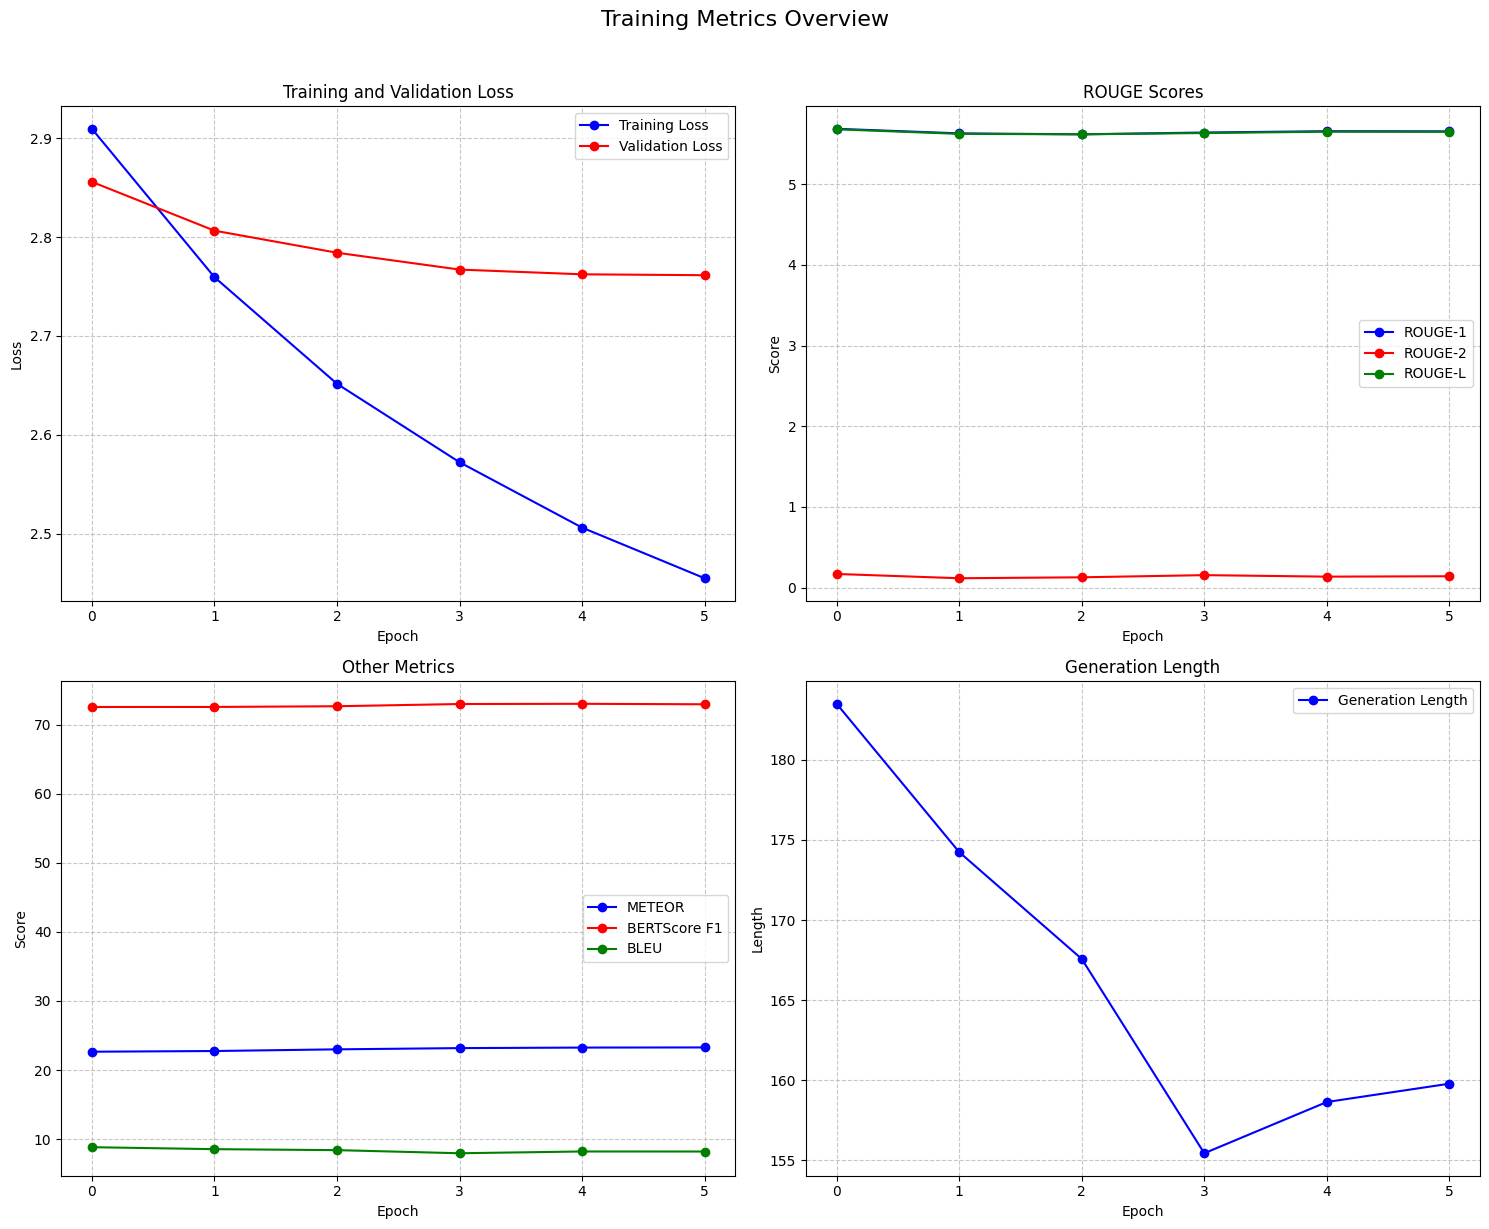


Final Metrics:
Train Loss: 2.4550
Validation Loss: 2.7614
ROUGE-1: 5.6565
ROUGE-2: 0.1414
ROUGE-L: 5.6502
METEOR: 23.2676
BERTScore: 72.9499
BLEU: 8.1975
Generation Length: 159.7882


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# nan 값을 제외하고 데이터 추출
train_loss = history_df['Training Loss'].dropna().values
eval_loss = history_df['Validation Loss'].dropna().values
rouge1 = history_df['Rouge1'].dropna().values
rouge2 = history_df['Rouge2'].dropna().values
rougeL = history_df['Rougel'].dropna().values
meteor = history_df['Meteor'].dropna().values
bertscore = history_df['Bertscore F1'].dropna().values
bleu = history_df['Bleu'].dropna().values
gen_len = history_df['Gen Len'].dropna().values

# 실제 데이터 개수에 맞춰 epochs 배열 생성
epochs = np.arange(len(eval_loss))

# 그래프 생성
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Training Metrics Overview', fontsize=16, y=1.02)

# Loss plot
ax1.plot(epochs, train_loss, 'b-', label='Training Loss', marker='o')
ax1.plot(epochs, eval_loss, 'r-', label='Validation Loss', marker='o')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# ROUGE scores over time
ax2.plot(epochs, rouge1, 'b-', label='ROUGE-1', marker='o')
ax2.plot(epochs, rouge2, 'r-', label='ROUGE-2', marker='o')
ax2.plot(epochs, rougeL, 'g-', label='ROUGE-L', marker='o')
ax2.set_title('ROUGE Scores')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Score')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

# Other metrics
ax3.plot(epochs, meteor, 'b-', label='METEOR', marker='o')
ax3.plot(epochs, bertscore, 'r-', label='BERTScore F1', marker='o')
ax3.plot(epochs, bleu, 'g-', label='BLEU', marker='o')
ax3.set_title('Other Metrics')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Score')
ax3.legend()
ax3.grid(True, linestyle='--', alpha=0.7)

# Generation length
ax4.plot(epochs, gen_len, 'b-', label='Generation Length', marker='o')
ax4.set_title('Generation Length')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Length')
ax4.legend()
ax4.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

# 그래프 저장
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# 최종 결과값들 출력
print("\nFinal Metrics:")
print(f"Train Loss: {train_loss[-1]:.4f}")
print(f"Validation Loss: {eval_loss[-1]:.4f}")
print(f"ROUGE-1: {rouge1[-1]:.4f}")
print(f"ROUGE-2: {rouge2[-1]:.4f}")
print(f"ROUGE-L: {rougeL[-1]:.4f}")
print(f"METEOR: {meteor[-1]:.4f}")
print(f"BERTScore: {bertscore[-1]:.4f}")
print(f"BLEU: {bleu[-1]:.4f}")
print(f"Generation Length: {gen_len[-1]:.4f}")